In [7]:
import os
import random
import pickle

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, auc, make_scorer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


In [3]:
# Load data
data_path = r'E:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\ecg_data.csv'
data = pd.read_csv(data_path, index_col=0)

# Splitting features and labels
x = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [5]:
# Load data
data_path_KNN = r'E:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\data\KNN_Final.csv'
data_path_RF = r'E:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\data\RF_hyperparameters.csv'

KNN_metrics = pd.read_csv(data_path_KNN, index_col=0)
RF_metrics = pd.read_csv(data_path_RF, index_col=0)

def get_mode_parameters(metrics, parameters):
    """
    Function to calculate the mode of specified parameters from the metrics DataFrame.

    Args:
        metrics (pd.DataFrame): DataFrame containing the metrics data.
        parameters (list): List of parameter column names to calculate the mode for.

    Returns:
        dict: Dictionary with parameter names as keys and their mode as values.
    """
    mode_values = {}
    for param in parameters:
        mode_values[param] = metrics[param].mode()[0]
        print(f"Mode of {param}:", mode_values[param])

    print("\n")
    return mode_values

# Example usage
KNN_parameters= ['knn__algorithm', 'knn__metric', 'knn__n_neighbors', 'knn__weights']
RF_parameters = ['n_estimators', 'min_samples_split', 'min_samples_leaf', 'max_samples', 'max_depth', 'bootstrap']

KNN_mode_values = get_mode_parameters(KNN_metrics, KNN_parameters)

RF_mode_values = get_mode_parameters(RF_metrics, RF_parameters)

Mode of knn__algorithm: auto
Mode of knn__metric: euclidean
Mode of knn__n_neighbors: 3
Mode of knn__weights: uniform


Mode of n_estimators: 69
Mode of min_samples_split: 3
Mode of min_samples_leaf: 1
Mode of max_samples: 0.500144539240563
Mode of max_depth: 16
Mode of bootstrap: True




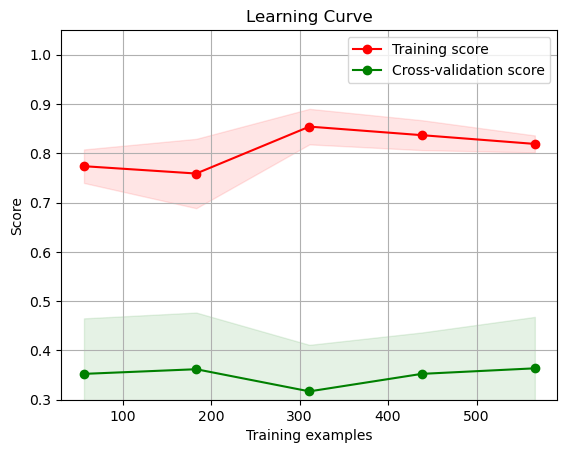

In [15]:
#prior split
X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, stratify=y, shuffle=True, random_state=7)

parameters = {
    'algorithm': 'auto',
    'metric': 'euclidean',
    'n_neighbors': 3,
    'weights': 'uniform',
}

pipeline = Pipeline([
    ('minmaxscaler', MinMaxScaler(feature_range=(0, 1))),
    ('pca', PCA(n_components=0.99, random_state=7)),
    ('rfc', KNeighborsClassifier(**parameters, n_jobs=-1))
])

pipeline.fit(X_test, y_test)
def pr_auc_score(y_true, y_pred_proba):
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        return auc(recall, precision)
pr_auc_scorer = make_scorer(pr_auc_score, needs_proba=True)

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=7), scoring=pr_auc_scorer, n_jobs=-1, random_state=7)


# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

# Plot the mean and standard deviation for training and test scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.ylim(0.3, 1.05)
plt.legend(loc="best")
plt.show()